In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as  plt

import torch
from torch.utils.data import DataLoader


# Importing modules from src
import os
import sys

sys.path.append(os.path.abspath('./../src'))
sys.path.append(os.path.abspath('./../src/architectures'))

from data_preprocessing.custom_preprocess import custom_preprocess
from data_preprocessing.custom_dataset import CustomDataset

from architectures.paral_conv_linear_arch1 import Parallel1DConvsLinearClass

from utils.live_plot import LivePlot

In [2]:
device = 'cuda'
torch.manual_seed(42)

# Preprocess data

In [3]:
df = pd.read_csv('./../sampled_df.csv')

In [4]:
X_train, X_dev, X_test, y_train, y_dev, y_test = custom_preprocess(df, dev_size=0.15, test_size=0.15, even_dist=True)

Processing started!
Checking if there are nan values...
Converting texts into matrices... (It may take a while, depending on df size)
Dividing dataset into train, dev and test subsets...
Done! returned: (X_train, X_dev, X_test, y_train, y_dev, y_test). Please, ensure that u received them properly (check variable names)


In [5]:
for subset in [X_train, X_dev, X_test, y_train, y_dev, y_test]:
  print(subset.shape)

torch.Size([7000, 300, 358])
torch.Size([1500, 300, 358])
torch.Size([1500, 300, 358])
torch.Size([7000, 1])
torch.Size([1500, 1])
torch.Size([1500, 1])


### Check distributions

In [12]:
%matplotlib inline

Text(0.5, 1.0, 'Label distribution in train set')

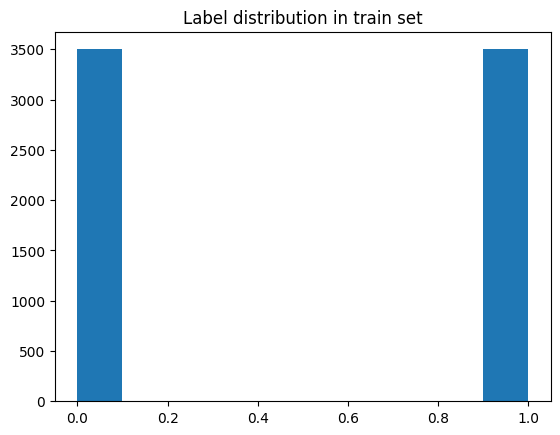

In [13]:
plt.hist(y_train.reshape(-1).cpu())
plt.title('Label distribution in train set')

Text(0.5, 1.0, 'Label distribution in dev set')

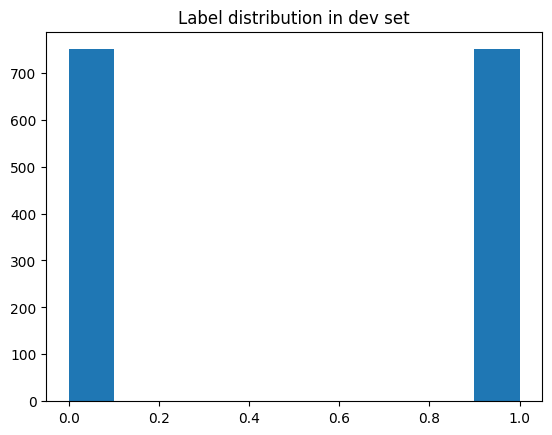

In [14]:
plt.hist(y_dev.reshape(-1).cpu())
plt.title('Label distribution in dev set')

Text(0.5, 1.0, 'Label distribution in test set')

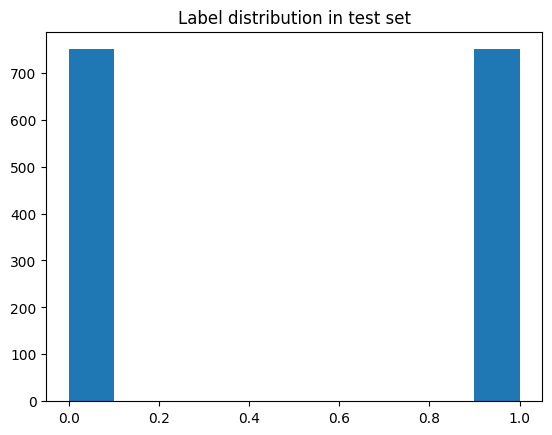

In [15]:
plt.hist(y_test.reshape(-1).cpu())
plt.title('Label distribution in test set')

### Making dataloaders

In [31]:
train_ds = CustomDataset(X_train, y_train)
dev_ds = CustomDataset(X_dev, y_dev)
test_ds = CustomDataset(X_test, y_test)

batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=True)
dev_dl = DataLoader(dev_ds, batch_size=batch_size, shuffle=False, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)


# That is how many examples are used now(truncated because of drop_last=True)
len(y_train) // batch_size * batch_size, len(y_dev) // batch_size * batch_size

(6912, 1408)

# Train